<a href="https://colab.research.google.com/github/ritwiks9635/Segmentation-Model/blob/main/Chest_XRay_Segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **💫Chest XRay Segmentation💫**

In [3]:
!rm -r /content/https:

In [4]:
import os
import cv2
import numpy as np
import pandas as pd
from glob import glob
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt

In [5]:
data_dir = "/content/Chest-X-Ray/Chest-X-Ray"
image_dir = os.path.join(data_dir, "image")
mask_dir = os.path.join(data_dir, "mask")
print("Total len of image :: ", len(os.listdir(image_dir)))
print("Total len of mask :: ", len(os.listdir(mask_dir)))

Total len of image ::  704
Total len of mask ::  704


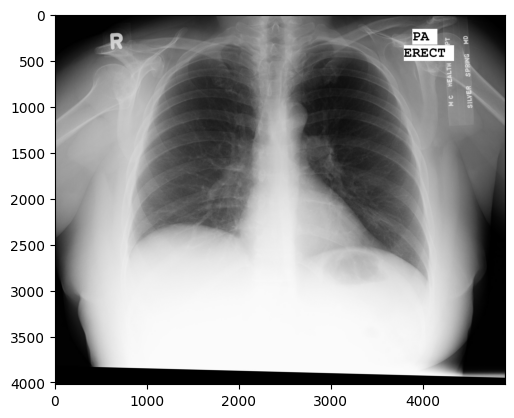

[  0 255]


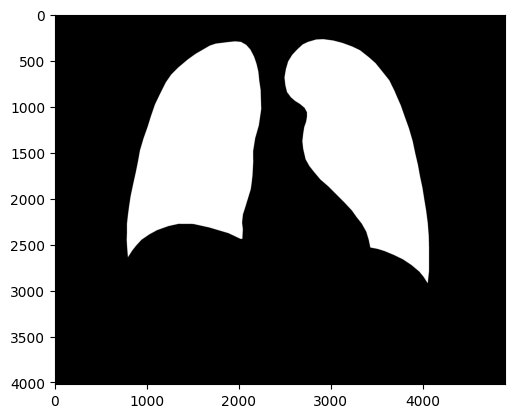

In [6]:
sam_img = os.path.join(image_dir, os.listdir(image_dir)[0])
sam_msk = os.path.join(mask_dir, os.listdir(mask_dir)[0])

img = cv2.imread(sam_img)
plt.imshow(img)
plt.show()

mask = cv2.imread(sam_msk)
print(np.unique(mask))
plt.imshow(mask)
plt.show()

In [7]:
print("Image shape is :: ", img.shape)
print("Mask shape is :: ", mask.shape)

Image shape is ::  (4020, 4892, 3)
Mask shape is ::  (4020, 4892, 3)


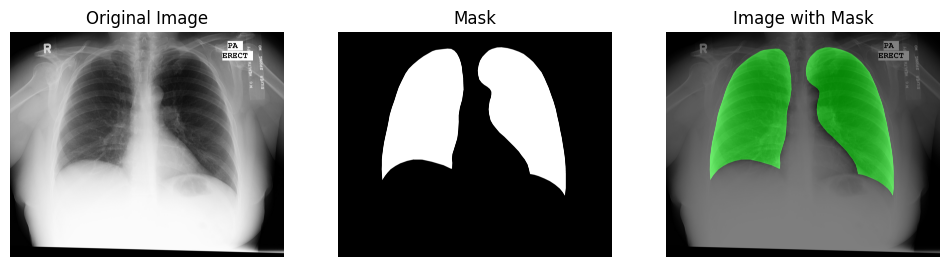

In [8]:
mask = cv2.resize(mask, (img.shape[1], img.shape[0]))

mask = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)

colored_mask = np.zeros_like(img)
colored_mask[:, :, 1] = mask

alpha = 0.5
overlayed_image = cv2.addWeighted(img, 1 - alpha, colored_mask, alpha, 0)

plt.figure(figsize=(12, 8))
plt.subplot(1, 3, 1)
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.title("Original Image")
plt.axis("off")

plt.subplot(1, 3, 2)
plt.imshow(mask, cmap="gray")
plt.title("Mask")
plt.axis("off")

plt.subplot(1, 3, 3)
plt.imshow(cv2.cvtColor(overlayed_image, cv2.COLOR_BGR2RGB))
plt.title("Image with Mask")
plt.axis("off")

plt.show()

In [9]:
batch_size = 4
image_size = 512
num_train_sample = int(len(os.listdir(image_dir)) * 0.9)

train_image_paths = sorted(glob(os.path.join(data_dir, "image/*")))[: num_train_sample]
train_mask_paths = sorted(glob(os.path.join(data_dir, "mask/*")))[: num_train_sample]

val_image_paths = sorted(glob(os.path.join(data_dir, "image/*")))[num_train_sample :]
val_mask_paths = sorted(glob(os.path.join(data_dir, "mask/*")))[num_train_sample :]

In [ ]:
print(train_image_paths[0])
print(train_mask_paths[0])

/content/Chest-X-Ray/Chest-X-Ray/image/1000.png
/content/Chest-X-Ray/Chest-X-Ray/mask/1000.png


In [10]:
def preprocess_data(data_path, mask = False):
    image = tf.io.read_file(data_path)
    if mask:
        image = tf.image.decode_png(image, channels = 1)
        image.set_shape([None, None, 1])
        image = tf.image.resize(image, size = [image_size, image_size])
        image = tf.cast(image, dtype=tf.float32) / 255.0
        image = tf.where(image > 0.5, 1.0, 0.0)
    else :
        image = tf.image.decode_png(image, channels = 1)
        image.set_shape([None, None, 1])
        image = tf.image.resize(image, size = [image_size, image_size])
        image = tf.cast(image, dtype=tf.float32) / 255.0
    return image


def load_data(image_path, mask_path):
    image = preprocess_data(image_path)
    mask = preprocess_data(mask_path, mask = True)
    return image, mask


def build_dataset(image_path, mask_path, shuffle=False):
    dataset = tf.data.Dataset.from_tensor_slices((image_path, mask_path))
    dataset = dataset.map(load_data, num_parallel_calls=tf.data.AUTOTUNE)
    if shuffle:
        dataset = dataset.shuffle(buffer_size=len(image_path))
    dataset = dataset.batch(batch_size, drop_remainder=True)
    dataset = dataset.prefetch(buffer_size=tf.data.AUTOTUNE)
    return dataset

In [11]:
train_dataset = build_dataset(train_image_paths, train_mask_paths, shuffle = True)
valid_dataset = build_dataset(val_image_paths, val_mask_paths)

Image shape: (4, 512, 512, 1), Mask shape: (4, 512, 512, 1)


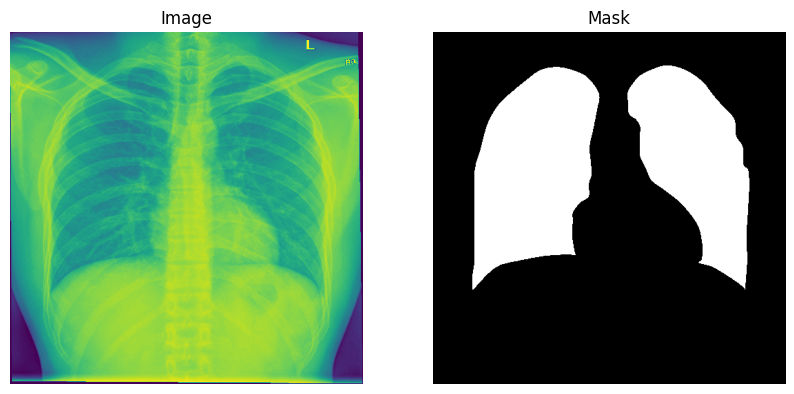

In [ ]:
for img, msk in train_dataset.take(1):
    print(f"Image shape: {img.shape}, Mask shape: {msk.shape}")
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(img[0])
    plt.title("Image")
    plt.axis("off")
    plt.subplot(1, 2, 2)
    plt.imshow(tf.squeeze(msk[0]), cmap='gray')
    plt.title("Mask")
    plt.axis("off")
    plt.show()

In [12]:
for img, mask in train_dataset.take(1):
    print("Image shape:", img.shape)
    print("Mask shape:", mask.shape)

Image shape: (4, 512, 512, 1)
Mask shape: (4, 512, 512, 1)


In [13]:
# Double convolution block
def double_conv_block(x, n_filters):
    x = layers.Conv2D(n_filters, 3, padding="same", activation="relu", kernel_initializer="he_normal")(x)
    x = layers.Conv2D(n_filters, 3, padding="same", activation="relu", kernel_initializer="he_normal")(x)
    return x

# Downsampling block
def downsample_block(x, n_filters):
    f = double_conv_block(x, n_filters)
    p = layers.MaxPool2D(2)(f)
    p = layers.Dropout(0.3)(p)
    return f, p


def upsample_block(x, conv_features, n_filters):
   # upsample
   x = layers.Conv2DTranspose(n_filters, 3, 2, padding="same")(x)
   # concatenate
   x = layers.concatenate([x, conv_features])
   # dropout
   x = layers.Dropout(0.3)(x)
   # Conv2D twice with ReLU activation
   x = double_conv_block(x, n_filters)

   return x

# U-Net model
def build_unet():
    inputs = layers.Input(shape=(512, 512, 1))

    # Encoder
    f1, p1 = downsample_block(inputs, 64)
    f2, p2 = downsample_block(p1, 128)
    f3, p3 = downsample_block(p2, 256)
    f4, p4 = downsample_block(p3, 512)

    # Bottleneck
    bottleneck = double_conv_block(p4, 1024)

    # Decoder
    u6 = upsample_block(bottleneck, f4, 512)
    u7 = upsample_block(u6, f3, 256)
    u8 = upsample_block(u7, f2, 128)
    u9 = upsample_block(u8, f1, 64)

    # Output
    outputs = layers.Conv2D(1, 1, padding="same", activation="sigmoid")(u9)

    # Model
    unet_model = tf.keras.Model(inputs, outputs, name="U-Net")
    return unet_model

# Build and summarize model
model = build_unet()
model.summary()

Model: "U-Net"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 512, 512, 1)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 512, 512, 64)   │            640 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 512, 512, 64)   │         36,928 │ conv2d[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 256, 256, 64)   │              0 │ conv2d_1[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout (Dropout)         │ (None, 256, 256, 64)   │              0 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 256, 256, 128)  │         73,856 │ dropout[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 256, 256, 128)  │        147,584 │ conv2d_2[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_1           │ (None, 128, 128, 128)  │              0 │ conv2d_3[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_1 (Dropout)       │ (None, 128, 128, 128)  │              0 │ max_pooling2d_1[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 128, 128, 256)  │        295,168 │ dropout_1[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_5 (Conv2D)         │ (None, 128, 128, 256)  │        590,080 │ conv2d_4[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_2           │ (None, 64, 64, 256)    │              0 │ conv2d_5[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_2 (Dropout)       │ (None, 64, 64, 256)    │              0 │ max_pooling2d_2[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_6 (Conv2D)         │ (None, 64, 64, 512)    │      1,180,160 │ dropout_2[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_7 (Conv2D)         │ (None, 64, 64, 512)    │      2,359,808 │ conv2d_6[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_3           │ (None, 32, 32, 512)    │              0 │ conv2d_7[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_3 (Dropout)       │ (None, 32, 32, 512)    │              0 │ max_pooling2d_3[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_8 (Conv2D)    

 Total params: 34,512,193 (131.65 MB)

 Trainable params: 34,512,193 (131.65 MB)

 Non-trainable params: 0 (0.00 B)

In [14]:
# Jaccard Index Metric
def jaccard_index(y_true, y_pred, smooth=100):
    """Calculates the Jaccard index (IoU), useful for evaluating the model's performance."""
    y_true_f = tf.reshape(tf.cast(y_true, tf.float32), [-1])  # Flatten and cast ground truth
    y_pred_f = tf.reshape(tf.cast(y_pred, tf.float32), [-1])  # Flatten and cast predictions
    intersection = tf.reduce_sum(y_true_f * y_pred_f)  # Compute intersection
    total = tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) - intersection  # Total pixels
    return (intersection + smooth) / (total + smooth)


def dice_coefficient(y_true, y_pred, smooth=1):
    # Flatten and cast true and predicted masks to float32
    y_true_f = tf.reshape(tf.cast(y_true, tf.float32), [-1])  # Flatten and cast y_true to float32
    y_pred_f = tf.reshape(tf.cast(y_pred, tf.float32), [-1])  # Flatten and cast y_pred to float32

    # Calculate the intersection between the true and predicted masks
    intersection = tf.reduce_sum(y_true_f * y_pred_f)

    # Calculate the Dice coefficient using the formula
    return (2. * intersection + smooth) / (tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) + smooth)

In [15]:
model.compile(optimizer=tf.keras.optimizers.Adam(),
                  loss="binary_crossentropy",
                  metrics=['accuracy',dice_coefficient,jaccard_index])

In [ ]:
epochs = 15
steps_per_epoch = len(train_image_paths) // batch_size
validation_steps = len(val_image_paths) // batch_size

early_stopping_cb = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)


history = model.fit(
    train_dataset,
    validation_data = valid_dataset,
    epochs = epochs,
    #steps_per_epoch = steps_per_epoch,
    callbacks = [early_stopping_cb])

Epoch 1/15
158/158 ━━━━━━━━━━━━━━━━━━━━ 344s 1s/step - accuracy: 0.7495 - dice_coefficient: 0.3167 - jaccard_index: 0.1921 - loss: 0.6163 - val_accuracy: 0.9164 - val_dice_coefficient: 0.7493 - val_jaccard_index: 0.5996 - val_loss: 0.2264
Epoch 2/15
158/158 ━━━━━━━━━━━━━━━━━━━━ 278s 976ms/step - accuracy: 0.9152 - dice_coefficient: 0.7348 - jaccard_index: 0.5844 - loss: 0.2185 - val_accuracy: 0.9191 - val_dice_coefficient: 0.8011 - val_jaccard_index: 0.6688 - val_loss: 0.2035
Epoch 3/15
158/158 ━━━━━━━━━━━━━━━━━━━━ 267s 998ms/step - accuracy: 0.9349 - dice_coefficient: 0.8042 - jaccard_index: 0.6752 - loss: 0.1691 - val_accuracy: 0.9385 - val_dice_coefficient: 0.8525 - val_jaccard_index: 0.7436 - val_loss: 0.1819
Epoch 4/15
158/158 ━━━━━━━━━━━━━━━━━━━━ 237s 1s/step - accuracy: 0.9582 - dice_coefficient: 0.8692 - jaccard_index: 0.7702 - loss: 0.1188 - val_accuracy: 0.9674 - val_dice_coefficient: 0.9173 - val_jaccard_index: 0.8478 - val_loss: 0.0987
Epoch 5/15
158/158 ━━━━━━━━━━━━━━━━━━━

Text(0.5, 1.0, 'Val loss')

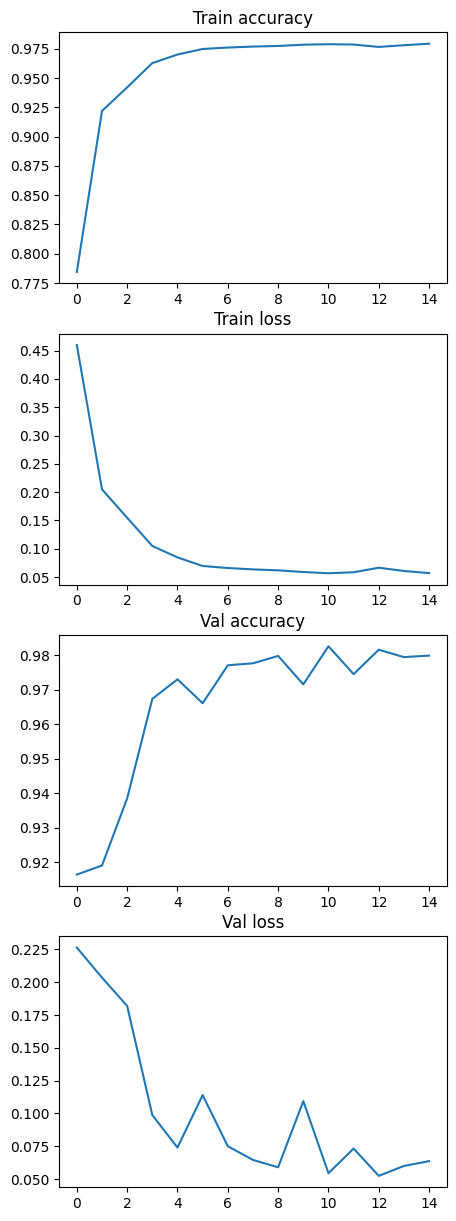

In [17]:
history = history.history
plt.figure(figsize=(5,15))
plt.subplot(4, 1, 1)
plt.plot(history["accuracy"])
plt.title("Train accuracy")

plt.subplot(4, 1, 2)
plt.plot(history["loss"])
plt.title("Train loss")

plt.subplot(4, 1, 3)
plt.plot(history["val_accuracy"])
plt.title("Val accuracy")

plt.subplot(4, 1, 4)
plt.plot(history["val_loss"])
plt.title("Val loss")

In [18]:
def get_colored_mask(image, mask_image,color = [255,20,255]):
    mask_image_gray = cv2.cvtColor(mask_image, cv2.COLOR_BGR2GRAY)
    mask = cv2.bitwise_and(mask_image, mask_image, mask=mask_image_gray)
    mask_coord = np.where(mask!=[0,0,0])
    mask[mask_coord[0],mask_coord[1],:]= color
    ret = cv2.addWeighted(image, 0.6, mask, 0.4, 0)
    return ret

In [19]:
def predict_and_display(dataset, model, num_samples=5, color_actual=[0, 255, 0], color_pred=[255, 0, 0]):


    for img, msk in dataset.take(num_samples):
        try:
            # Convert tensors to NumPy arrays
            img = img.numpy()[0, ...]  # Remove batch dimension
            msk = msk.numpy()[0, ...]  # Remove batch dimension

            # Ensure the input has the correct shape
            input_image = np.expand_dims(img, axis=0)  # Add batch dimension

            # Generate predictions
            pred = model.predict(input_image, verbose=0)
            pred = (np.squeeze(pred) * 255).astype(np.uint8)  # Convert to 8-bit grayscale

            # Convert grayscale images to RGB
            img_rgb = cv2.cvtColor((img * 255).astype(np.uint8), cv2.COLOR_GRAY2RGB)
            msk_rgb = cv2.cvtColor((msk * 255).astype(np.uint8), cv2.COLOR_GRAY2RGB)
            pred_rgb = cv2.cvtColor(pred, cv2.COLOR_GRAY2RGB)

            # Apply colors to masks
            msk_colored = get_colored_mask(img_rgb, msk_rgb, color=color_actual)
            pred_colored = get_colored_mask(img_rgb, pred_rgb, color=color_pred)

            # Display results
            plt.figure(figsize=(12, 4))
            plt.subplot(1, 3, 1)
            plt.imshow(img_rgb)
            plt.title("Input Image")
            plt.axis("off")

            plt.subplot(1, 3, 2)
            plt.imshow(msk_colored)
            plt.title("Actual Mask")
            plt.axis("off")

            plt.subplot(1, 3, 3)
            plt.imshow(pred_colored)
            plt.title("Predicted Mask")
            plt.axis("off")

            plt.tight_layout()
            plt.show()

        except Exception as e:
            print(f"Error during prediction: {e}")
            print(f"Input image shape: {input_image.shape}")

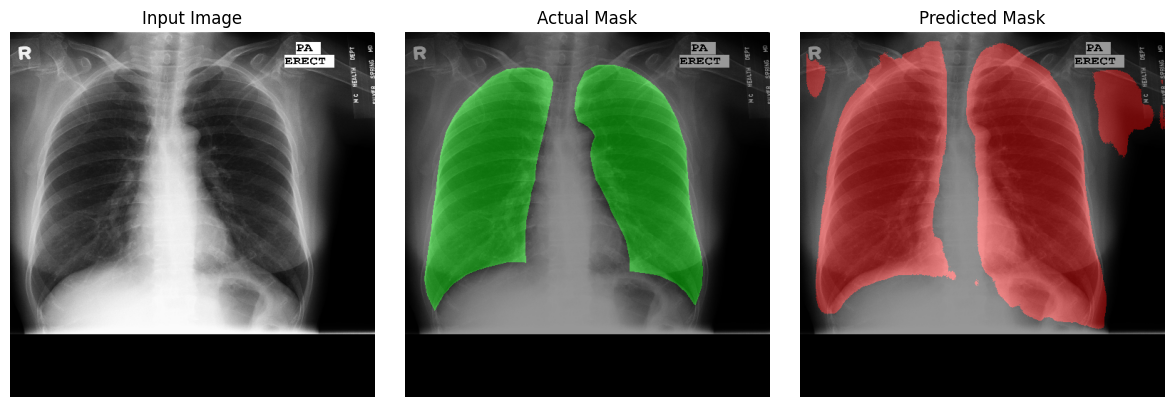

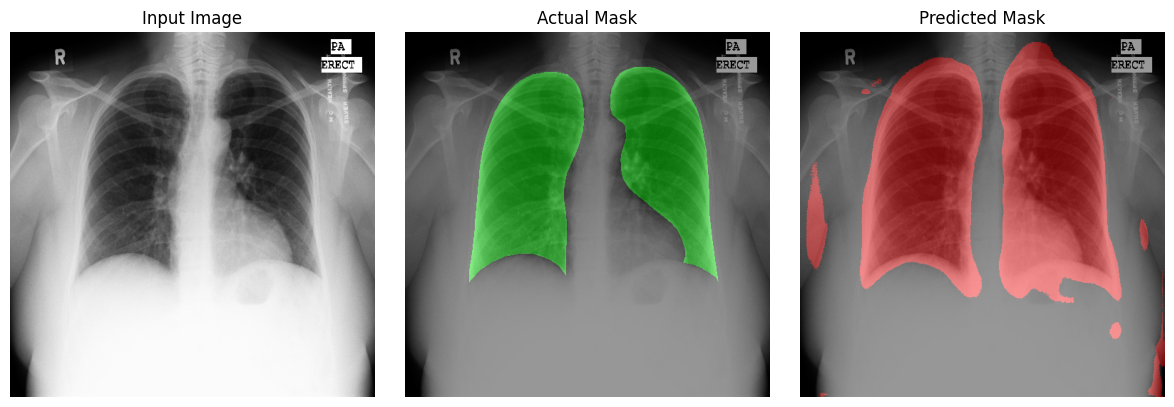

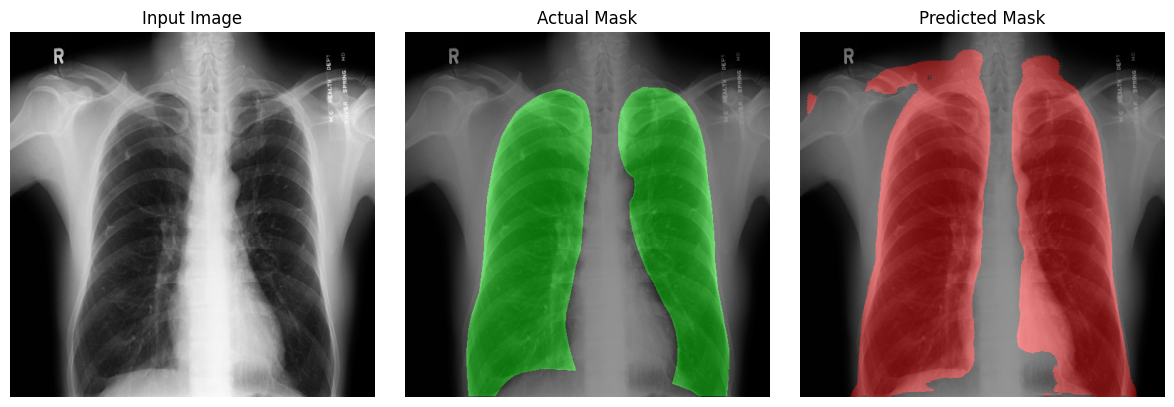

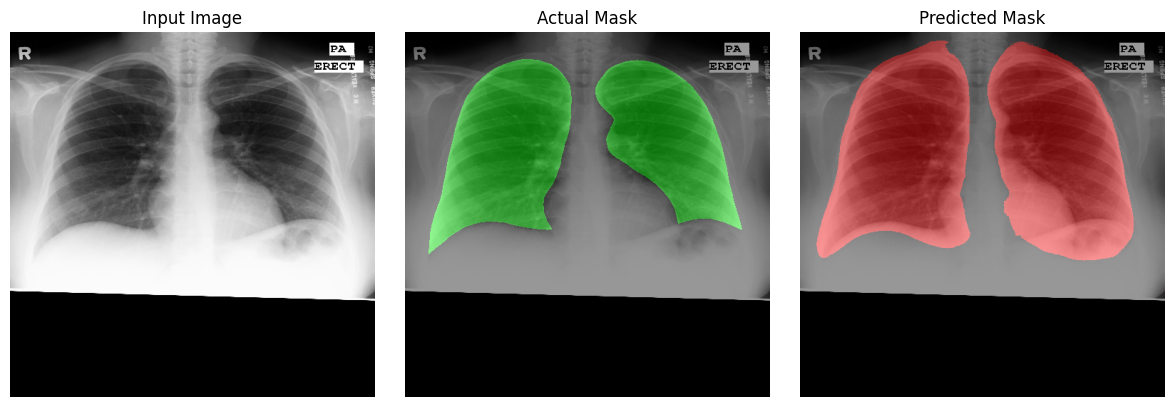

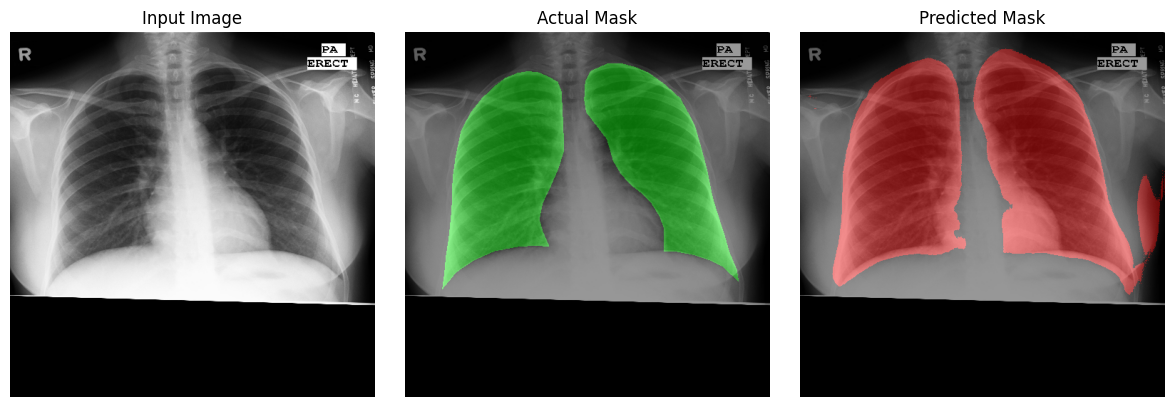

In [20]:
predict_and_display(valid_dataset, model)